In [1]:
import pandas as pd
data=pd.read_csv("./china.csv")
data

,新增确诊,新增治愈,新增死亡,统计日期
0,0,4,0,1月11日
1,0,1,0,1月12日
2,0,5,1,1月13日
3,41,12,2,1月16日
4,45,15,2,1月17日
...,...,...,...,...
413,27,41,0,3月3日
414,20,25,1,3月4日
415,21,26,0,3月5日
416,28,35,2,3月6日


In [2]:
data.pop("统计日期")
data=data.values


In [3]:
import numpy as np
window=30#窗口长度
max_=np.max(data,axis=0,keepdims=True)
min_=np.min(data,axis=0,keepdims=True)
data=(data-min_)/(max_-min_)#归一化
# data=data*2-1
seq=[]
target=[]
for i in range(window+1,len(data)):#构建数据集
    seq.append(data[i-window:i,:][np.newaxis,:,:])
    target.append(data[i:i+1,:])
seq=np.concatenate(seq,axis=0)[:,:,:,np.newaxis]
target=np.concatenate(target,axis=0)
print(seq.shape,target.shape)

(387, 30, 3, 1) (387, 3)


In [4]:
# #划分训练集和测试集
# test_size=0.2#测试集占2%
# X_train,X_test=seq[int(len(seq)*0.2):,:,:],seq[:int(len(seq)*0.2),:,:]
# y_train,y_test=target[int(len(seq)*0.2):],target[:int(len(seq)*0.2)]
from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test=train_test_split(seq,target,test_size=0.25,random_state=2021,shuffle=True)
test_size=0.2
X_train,X_test=seq[int(len(seq)*0.2):,:,:],seq[:int(len(seq)*0.2),:,:]
y_train,y_test=target[int(len(seq)*0.2):,:],target[:int(len(seq)*0.2),:]
# print(type(X_train),type(y_train))
print(X_test)

[[[[0.00000000e+00]
   [1.93118757e-01]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [1.94006659e-01]
   [7.75193798e-04]]

  [[2.70787927e-03]
   [1.95560488e-01]
   [1.55038760e-03]]

  ...

  [[1.00000000e+00]
   [4.48168701e-01]
   [1.96899225e-01]]

  [[2.67617727e-01]
   [3.83573807e-01]
   [1.00775194e-02]]

  [[1.74493098e-01]
   [5.01664817e-01]
   [1.10852713e-01]]]


 [[[0.00000000e+00]
   [1.94006659e-01]
   [7.75193798e-04]]

  [[2.70787927e-03]
   [1.95560488e-01]
   [1.55038760e-03]]

  [[2.97206261e-03]
   [1.96226415e-01]
   [1.55038760e-03]]

  ...

  [[2.67617727e-01]
   [3.83573807e-01]
   [1.00775194e-02]]

  [[1.74493098e-01]
   [5.01664817e-01]
   [1.10852713e-01]]

  [[1.32553992e-01]
   [4.91453940e-01]
   [1.10077519e-01]]]


 [[[2.70787927e-03]
   [1.95560488e-01]
   [1.55038760e-03]]

  [[2.97206261e-03]
   [1.96226415e-01]
   [1.55038760e-03]]

  [[1.81626048e-02]
   [1.95116537e-01]
   [3.10077519e-03]]

  ...

  [[1.74493098e-01]
   [5.01664817e-01]
   [1

In [5]:
from tensorflow.keras import layers,Sequential
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
log_dir="log/CNN"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

tf.random.set_seed(2021)
db_train=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(10)
db_test=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(10)

model=Sequential()
model.add(layers.Input(shape=(30,3,1),dtype=tf.float32))
model.add(layers.Conv2D(filters=20,kernel_size=(20,2),strides=(1,1),padding="same",activation=tf.nn.leaky_relu))#CNN，filters卷积核数量，kernel_size卷积核大小，strides步长，padding填充
model.add(layers.Conv2D(filters=10,kernel_size=(10,2),strides=(1,1),padding="same",activation=tf.nn.leaky_relu))#CNN，filters卷积核数量，kernel_size卷积核大小，strides步长，padding填充
model.add(layers.Conv2D(filters=20,kernel_size=(2,2),strides=(1,1),padding="same",activation=tf.nn.leaky_relu))#CNN
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))#最大池化，pool_size池化核大小，stride步长，padding填充
model.add(layers.Flatten())#压平
model.add(layers.Dense(500,activation=tf.nn.leaky_relu))#全连接层，激活函数为leaky relu，输出大小为20
model.add(layers.Dense(100,activation=tf.nn.leaky_relu))#全连接层，激活函数为leaky relu，输出大小为20
model.add(layers.Dense(50,activation=tf.nn.leaky_relu))#全连接层，激活函数为leaky relu，输出大小为20
# model.add(layers.Dense(20,activation=tf.nn.leaky_relu))#全连接层，激活函数为leaky relu，输出大小为20
model.add(layers.Dense(3))#全连接层，输出大小为3
model.summary()#总打印模型信息
model.compile(optimizer=tf.optimizers.Adam(),  
              loss=tf.losses.MSE,
              metrics=tf.keras.metrics.MeanAbsoluteError())#编译，Adam优化器，MSE损失
his =model.fit(db_train,validation_data=db_test,validation_freq=1,epochs=355,callbacks=[tensorboard])#训练

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 3, 20)         820       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 3, 10)         4010      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 3, 20)         820       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 2, 20)         0         
_________________________________________________________________
flatten (Flatten)            (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               300500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5

31/31 [==============================] - 1s 21ms/step - loss: 9.8567e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0279 - val_mean_absolute_error: 0.0774
Epoch 41/355
31/31 [==============================] - 0s 15ms/step - loss: 9.9234e-05 - mean_absolute_error: 0.0060 - val_loss: 0.0281 - val_mean_absolute_error: 0.0776
Epoch 42/355
31/31 [==============================] - 1s 17ms/step - loss: 9.9359e-05 - mean_absolute_error: 0.0060 - val_loss: 0.0279 - val_mean_absolute_error: 0.0780
Epoch 43/355
31/31 [==============================] - 0s 13ms/step - loss: 9.8013e-05 - mean_absolute_error: 0.0059 - val_loss: 0.0278 - val_mean_absolute_error: 0.0769
Epoch 44/355
31/31 [==============================] - 0s 14ms/step - loss: 9.7199e-05 - mean_absolute_error: 0.0058 - val_loss: 0.0280 - val_mean_absolute_error: 0.0783
Epoch 45/355
31/31 [==============================] - 1s 34ms/step - loss: 9.5402e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0279 - val_mean_absolute_error: 0.0776

31/31 [==============================] - 1s 19ms/step - loss: 9.4088e-05 - mean_absolute_error: 0.0055 - val_loss: 0.0315 - val_mean_absolute_error: 0.1071
Epoch 89/355
31/31 [==============================] - 0s 14ms/step - loss: 9.2322e-05 - mean_absolute_error: 0.0057 - val_loss: 0.0304 - val_mean_absolute_error: 0.1035
Epoch 90/355
31/31 [==============================] - 1s 24ms/step - loss: 9.3551e-05 - mean_absolute_error: 0.0058 - val_loss: 0.0316 - val_mean_absolute_error: 0.1071
Epoch 91/355
31/31 [==============================] - 1s 20ms/step - loss: 9.5223e-05 - mean_absolute_error: 0.0061 - val_loss: 0.0306 - val_mean_absolute_error: 0.1039
Epoch 92/355
31/31 [==============================] - 1s 18ms/step - loss: 8.8588e-05 - mean_absolute_error: 0.0059 - val_loss: 0.0305 - val_mean_absolute_error: 0.1040
Epoch 93/355
31/31 [==============================] - 1s 17ms/step - loss: 8.9895e-05 - mean_absolute_error: 0.0056 - val_loss: 0.0330 - val_mean_absolute_error: 0.1088

31/31 [==============================] - 0s 14ms/step - loss: 3.4841e-05 - mean_absolute_error: 0.0044 - val_loss: 0.0115 - val_mean_absolute_error: 0.0621
Epoch 137/355
31/31 [==============================] - 0s 14ms/step - loss: 3.2304e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0078 - val_mean_absolute_error: 0.0456
Epoch 138/355
31/31 [==============================] - 0s 16ms/step - loss: 3.2344e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0099 - val_mean_absolute_error: 0.0551
Epoch 139/355
31/31 [==============================] - 0s 13ms/step - loss: 2.8050e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0101 - val_mean_absolute_error: 0.0551
Epoch 140/355
31/31 [==============================] - 0s 14ms/step - loss: 3.0959e-05 - mean_absolute_error: 0.0040 - val_loss: 0.0081 - val_mean_absolute_error: 0.0474
Epoch 141/355
31/31 [==============================] - 0s 15ms/step - loss: 2.8432e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0137 - val_mean_absolute_error: 0

31/31 [==============================] - 0s 15ms/step - loss: 1.5918e-05 - mean_absolute_error: 0.0029 - val_loss: 0.0234 - val_mean_absolute_error: 0.0922
Epoch 185/355
31/31 [==============================] - 1s 17ms/step - loss: 3.1244e-05 - mean_absolute_error: 0.0043 - val_loss: 0.0141 - val_mean_absolute_error: 0.0684
Epoch 186/355
31/31 [==============================] - 1s 19ms/step - loss: 3.0613e-05 - mean_absolute_error: 0.0040 - val_loss: 0.0078 - val_mean_absolute_error: 0.0446
Epoch 187/355
31/31 [==============================] - 1s 17ms/step - loss: 2.1980e-05 - mean_absolute_error: 0.0036 - val_loss: 0.0164 - val_mean_absolute_error: 0.0744
Epoch 188/355
31/31 [==============================] - 2s 68ms/step - loss: 2.2686e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0105 - val_mean_absolute_error: 0.0584
Epoch 189/355
31/31 [==============================] - 1s 36ms/step - loss: 1.6066e-05 - mean_absolute_error: 0.0028 - val_loss: 0.0194 - val_mean_absolute_error: 0

31/31 [==============================] - 1s 47ms/step - loss: 5.0980e-05 - mean_absolute_error: 0.0044 - val_loss: 0.0090 - val_mean_absolute_error: 0.0479
Epoch 233/355
31/31 [==============================] - 1s 34ms/step - loss: 9.8372e-05 - mean_absolute_error: 0.0067 - val_loss: 0.0095 - val_mean_absolute_error: 0.0517
Epoch 234/355
31/31 [==============================] - 1s 24ms/step - loss: 4.4743e-05 - mean_absolute_error: 0.0048 - val_loss: 0.0115 - val_mean_absolute_error: 0.0583
Epoch 235/355
31/31 [==============================] - 1s 18ms/step - loss: 5.3645e-05 - mean_absolute_error: 0.0053 - val_loss: 0.0198 - val_mean_absolute_error: 0.0821
Epoch 236/355
31/31 [==============================] - 1s 18ms/step - loss: 3.7161e-05 - mean_absolute_error: 0.0041 - val_loss: 0.0111 - val_mean_absolute_error: 0.0619
Epoch 237/355
31/31 [==============================] - 1s 20ms/step - loss: 2.3018e-05 - mean_absolute_error: 0.0038 - val_loss: 0.0091 - val_mean_absolute_error: 0

31/31 [==============================] - 0s 14ms/step - loss: 1.2212e-05 - mean_absolute_error: 0.0023 - val_loss: 0.0269 - val_mean_absolute_error: 0.0868
Epoch 281/355
31/31 [==============================] - 0s 14ms/step - loss: 1.5525e-05 - mean_absolute_error: 0.0029 - val_loss: 0.0213 - val_mean_absolute_error: 0.0717
Epoch 282/355
31/31 [==============================] - 1s 16ms/step - loss: 1.3657e-05 - mean_absolute_error: 0.0026 - val_loss: 0.0270 - val_mean_absolute_error: 0.0834
Epoch 283/355
31/31 [==============================] - 0s 15ms/step - loss: 1.2021e-05 - mean_absolute_error: 0.0025 - val_loss: 0.0176 - val_mean_absolute_error: 0.0670
Epoch 284/355
31/31 [==============================] - 1s 18ms/step - loss: 1.2116e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0315 - val_mean_absolute_error: 0.0935
Epoch 285/355
31/31 [==============================] - 0s 16ms/step - loss: 1.7625e-05 - mean_absolute_error: 0.0030 - val_loss: 0.0181 - val_mean_absolute_error: 0

31/31 [==============================] - 0s 16ms/step - loss: 3.0118e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0185 - val_mean_absolute_error: 0.0673
Epoch 329/355
31/31 [==============================] - 0s 15ms/step - loss: 1.6625e-05 - mean_absolute_error: 0.0027 - val_loss: 0.0326 - val_mean_absolute_error: 0.0898
Epoch 330/355
31/31 [==============================] - 0s 15ms/step - loss: 4.8332e-05 - mean_absolute_error: 0.0047 - val_loss: 0.0255 - val_mean_absolute_error: 0.0838
Epoch 331/355
31/31 [==============================] - 0s 14ms/step - loss: 1.7319e-05 - mean_absolute_error: 0.0028 - val_loss: 0.0209 - val_mean_absolute_error: 0.0724
Epoch 332/355
31/31 [==============================] - 1s 19ms/step - loss: 3.9402e-05 - mean_absolute_error: 0.0040 - val_loss: 0.0168 - val_mean_absolute_error: 0.0655
Epoch 333/355
31/31 [==============================] - 1s 22ms/step - loss: 1.6664e-05 - mean_absolute_error: 0.0028 - val_loss: 0.0205 - val_mean_absolute_error: 0

In [6]:
# import  matplotlib.pyplot as plt
# # his = model.fit(X_train, epochs=epochs, validation_data=val_ds)
# # his =model.fit(db_train,validation_data=db_test,validation_freq=1,epochs=60,callbacks=[tensorboard])
# # model.save_weights('./20epoch_(90%-2).h5', overwrite=True)

# # 损失
# fig, ax = plt.subplots(figsize=[5,7])
# ax.plot(his.history['loss'], label='train_loss')
# ax.plot(his.history['val_loss'], label='val_loss')
# ax.legend()
# ax.set_xlabel('epochs')
# ax.set_ylabel('losses')
# ax.set_title('CNN')
# plt.show()

In [7]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
# predict=model.predict(X_test)#预测
# predict=predict*(max_-min_)+min_#反归一化
# y=y_test*(max_-min_)+min_#反归一化
predict=model.predict(X_test)
# predict=predict*(max_-min_)+min_
predict[predict<0]=0
y=y_test
# y=y_test*(max_-min_)+min_
# "新增确诊	"
print(r2_score(y[:,0],predict[:,0]))#R^2
print(mean_absolute_error(y[:,0],predict[:,0]))#MAE
print(mean_absolute_percentage_error(y[:,0],predict[:,0]))#MAPE
print(mean_squared_error(y[:,0],predict[:,0]))#MSE
print()
# "新增治愈"
print(r2_score(y[:,1],predict[:,1]))
print(mean_absolute_error(y[:,1],predict[:,1]))
print(mean_absolute_percentage_error(y[:,1],predict[:,1]))
print(mean_squared_error(y[:,1],predict[:,1]))
print()
# "新增死亡"
print(r2_score(y[:,2],predict[:,2]))
print(mean_absolute_error(y[:,1],predict[:,1]))
print(mean_absolute_percentage_error(y[:,1],predict[:,1]))
print(mean_squared_error(y[:,1],predict[:,1]))
print()

0.6879977394536145
0.009405297683060683
1.474344415570021
0.00025904453530588886

0.2753231889736607
0.11891623046714432
12717842650737.248
0.03352494480546686

-0.009079873035719999
0.11891623046714432
12717842650737.248
0.03352494480546686



In [8]:
predict=predict*(max_-min_)+min_
y=y_test*(max_-min_)+min_

Text(0.5, 1.0, '新增确诊')

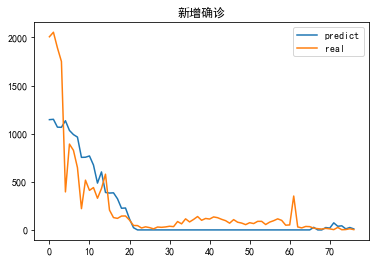

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(predict[:,0],label="predict")
plt.plot(y[:,0],label="real")
plt.legend(loc="best")
plt.title("新增确诊")

Text(0.5, 1.0, '新增治愈')

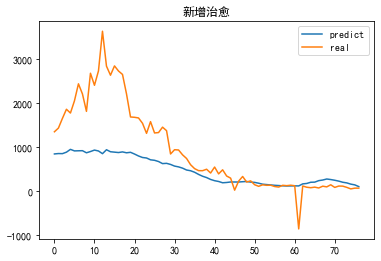

In [14]:

plt.plot(predict[:,1],label="predict")
plt.plot(y[:,1],label="real")
plt.legend(loc="best")
plt.title("新增治愈")


Text(0.5, 1.0, '新增死亡')

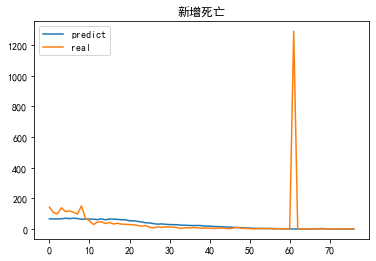

In [18]:

plt.plot(predict[:,2],label="predict")
plt.plot(y[:,2],label="real")
plt.legend(loc="best")
plt.title("新增死亡")